# Building model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
import datetime


In [2]:
# build_rgb_stream
def build_rgb_stream(input_shape=(640, 640, 3), num_frames=20):
    model = models.Sequential()

    # Add convolutional layers for image processing
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', input_shape=(num_frames,) + input_shape))
    model.add(layers.MaxPooling3D((1, 1)))
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((1, 2, 2)))
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((1, 2, 2)))

    # Add TimeDistributed layer for processing each frame separately
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    return model

In [3]:
# build_pose_stream
def build_pose_stream(input_shape=(20, 17*2)):
    model = models.Sequential()

    # Add LSTM layers for processing pose keypoints over time
    model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(256, return_sequences=True))

    model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dropout(0.5))

    return model


In [4]:
# build_fusion_model
def build_fusion_model(rgb_stream, pose_stream, num_classes):
    # Combine the two streams
    rgb_stream_flattened = layers.Flatten()(rgb_stream.output)
    pose_stream_flattened = layers.Flatten()(pose_stream.output)
    # combined_input = layers.concatenate([pose_stream_flattened])

    # Add fully connected layers for fusion
    fusion_dense = layers.Dense(512, activation='relu')(pose_stream_flattened) # replace with (combined_input)
    # fusion_dense = layers.Dropout(0.5)(fusion_dense)

    fusion_output = layers.Dense(num_classes, activation='sigmoid')(fusion_dense)

    # Create the final model
    fusion_model = models.Model(inputs=[pose_stream.input], outputs=fusion_output)

    return fusion_model


In [5]:
# Set the number of classes for your action recognition task
num_classes = 22

# Build the RGB stream
rgb_stream = build_rgb_stream()

# Build the Pose stream
pose_stream = build_pose_stream(input_shape=(10, 34))

# Build the Fusion model
fusion_model = build_fusion_model(rgb_stream, pose_stream, num_classes)


# Define hyperparameters
hp_epochs = hp.HParam('epochs', hp.IntInterval(10, 50))
hp_learning_rate = hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2))

# Create a summary file for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create a callback for hyperparameter logging
hparams_callback = hp.KerasCallback(log_dir, hparams={hp_epochs: 20, hp_learning_rate: 1e-3})


# Compile the model with an appropriate optimizer, loss, and metrics
fusion_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'binary_accuracy'])

# Display the model summary
fusion_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 10, 34)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            25344     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 10, 256)           394240    
                                                                 
 dense_1 (Dense)             (None, 10, 256)           65792     
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               131123

In [6]:
tf.keras.utils.plot_model(fusion_model, to_file='model_plot.png',
                           show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
fusion_model.input_shape

(None, 10, 34)

# Prepare Dataset


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report


In [10]:
# df = pd.read_csv('keypoint_dataset/keypoints_df_10frames_20240203_180300.csv') 

# df[:2]

# df.columns = ['keypoints', 'target']
# df['keypoints'] = df['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((20, 34)))
# df['target'] = df['target'].apply(lambda x: 0 if x=='WalkingWithDog' else 1)


In [11]:
df = pd.read_csv('keypoint_dataset/JHMDB/keypoints_df_20240204_185750.csv') 

df[:2]

df.columns = ['keypoints', 'target']
df['keypoints'] = df['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((20, 34)))

In [12]:
# df.columns = ['keypoints', 'target']

In [13]:
# df['keypoints'] = df['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((20, 34)))
# df['0'] = df['0'].apply(lambda arr: np.pad(arr, ((0, max(0, 20 - arr.shape[0])), (0, 0)), mode='constant', constant_values=0))

In [14]:
# df['target'] = df['target'].apply(lambda x: 0 if x=='WalkingWithDog' else 1)
# df['target'] = df['target'].apply(lambda x: 0 if x=='walking' else 1)

In [15]:
df['target'].value_counts()

target
pullup            55
shoot_gun         55
pour              55
swing_baseball    54
shoot_bow         53
catch             48
throw             46
clap              44
push              42
wave              42
golf              42
walk              41
brush_hair        41
pick              40
run               40
shoot_ball        40
climb_stairs      40
jump              39
sit               39
stand             36
kick_ball         35
Name: count, dtype: int64

# training

In [16]:
from sklearn.model_selection import train_test_split
X = np.asarray(df['keypoints'].tolist())
y = np.asarray(df['target'])



In [17]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['target'])

y = to_categorical(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
import tensorflow as tf

In [20]:
y_train.shape

(649, 22)

In [21]:

history = fusion_model.fit(
    X_train,  # Replace rgb_data and pose_data with your actual training data
    y_train,  # Replace labels with your actual training labels
    epochs=100,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_data=(X_test, y_test)  # Set the validation split as needed
)

# Launch TensorBoard for real-time visualization
%tensorboard --logdir logs/fit

Epoch 1/100
21/21 [==============================] - 6s 75ms/step - loss: 0.2618 - accuracy: 0.0616 - binary_accuracy: 0.9364 - val_loss: 0.1878 - val_accuracy: 0.0502 - val_binary_accuracy: 0.9545
Epoch 2/100
21/21 [==============================] - 0s 23ms/step - loss: 0.1823 - accuracy: 0.1017 - binary_accuracy: 0.9543 - val_loss: 0.1769 - val_accuracy: 0.1183 - val_binary_accuracy: 0.9545
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 0.1726 - accuracy: 0.1002 - binary_accuracy: 0.9545 - val_loss: 0.1790 - val_accuracy: 0.0824 - val_binary_accuracy: 0.9545
Epoch 4/100
21/21 [==============================] - 1s 25ms/step - loss: 0.1667 - accuracy: 0.1510 - binary_accuracy: 0.9540 - val_loss: 0.1770 - val_accuracy: 0.0932 - val_binary_accuracy: 0.9545
Epoch 5/100
21/21 [==============================] - 0s 24ms/step - loss: 0.1603 - accuracy: 0.1787 - binary_accuracy: 0.9550 - val_loss: 0.1921 - val_accuracy: 0.0717 - val_binary_accuracy: 0.9441
Epoch 6/10

UsageError: Line magic function `%tensorboard` not found.


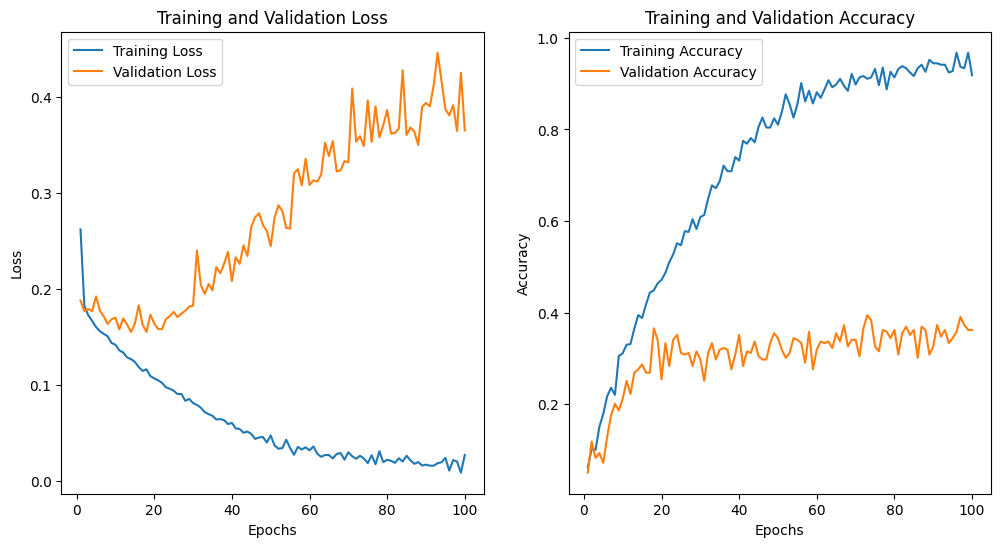

: 

In [22]:
import matplotlib.pyplot as plt

# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
fusion_model.save('models/detector.keras', overwrite=False)

[TIP] Next time specify overwrite=True!


In [21]:
X[0].shape

(20, 34)

<Axes: >

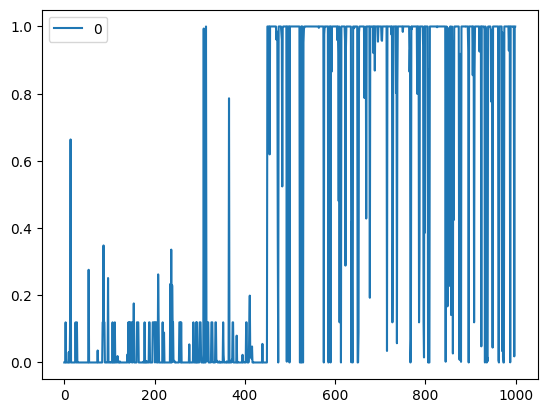

In [23]:
pd.DataFrame(fusion_model(np.array(X))).plot()

In [22]:
X[200:210].shape

(10, 20, 34)

In [52]:

print(fusion_model(np.array(X[200:205])))

tf.Tensor(
[[0.61548716]
 [0.6404425 ]
 [0.63436747]
 [0.63190275]
 [0.64873147]], shape=(5, 1), dtype=float32)


In [26]:
# load model
from keras.models import load_model
model = load_model('models/detector.keras')

In [30]:
X[:10].shape

(10, 20, 34)

In [36]:
model.predict(X[:10])

1/1 [==============================] - 0s 13ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [37]:
model